### Connect to the database to create a basic version of the visual web page, the code is as follows: ###

In [ ]:
import pandas as pd
import pymysql as pm
import time
import geopandas as gpd
from shapely import geometry
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import mapclassify as mc
import geoplot as gplt
import matplotlib
import matplotlib.patches as mpatches
import geoplot.crs as gcrs
import pyproj
from pyecharts.charts import Geo # Import geographic information processing module
from pyecharts import options as opts  # Configuration
from pyecharts.render import make_snapshot # Snapshot
from snapshot_selenium import snapshot 
from pyecharts.globals import ChartType, SymbolType # Global configuration

# Create connection object

conn = pm.connect(host = 'localhost' , port = 3306 , user = 'root' , password = '123456' , db = 'fever_clinic' , charset = 'utf8' ,
                  cursorclass = pm.cursors.DictCursor)
try:

# Obtain the cursor object
    
    with conn.cursor() as cursor:
        
# Execute SQL to get the result
        
        cursor.execute('select Hospital_Name,Hospital_Grade,Beds_Number,Longitude,Latitude from tb_nationalfeverclinic')
        data = cursor.fetchall()
        geo_sight_coord = {row['Hospital_Name'].strip(): [row['Longitude'] , row['Latitude']] for row in data} # Construct location dictionary data
        data_pair = []
        for row in data:
            if row['Hospital_Grade'] == 'Tertiary':
                data_pair.append((row['Hospital_Name'] , 3))
            elif row['Hospital_Grade'] == 'Secondary':
                data_pair.append((row['Hospital_Name'] , 2))
            elif row['Hospital_Grade'] == 'Primary':
                data_pair.append((row['Hospital_Name'] , 1))
            elif row['Hospital_Grade'] == 'Non-level':
                data_pair.append((row['Hospital_Name'] , 4))
except pm.MySQLError as error:
    print('Error！！')
    print(error)
finally:

# Close connection to release resources
    
    conn.close()

g=Geo(init_opts=opts.InitOpts(height='850px',width='1850px',bg_color='lightcyan')) # Geographical initialization
g.add_schema(maptype="china") # Limited scope
for key, value in geo_sight_coord.items(): # Cycle to geographic points
    g.add_coordinate(key, value[0], value[1]) # Additional point position

g.add("", data_pair, symbol_size=4) 
g.set_series_opts(label_opts=opts.LabelOpts(is_show=False), type='scatter')  # Scatter plot

fenlei = [
        {'min': 0, 'max': 1.5, 'label': 'Primary', 'color': '#00B2EE'},
        {'min': 1.5, 'max': 2.5, 'label': 'Secondary', 'color': '#71C671'},
        {'min': 2.5, 'max': 3.5, 'label': 'Tertiary', 'color': '#CD4F39'},
        {'min': 3.5, 'max': 4.5, 'label': 'Non-level','color': '#FF0000'} # There is a lower limit and no upper limit
         ]

g.set_global_opts(tooltip_opts=opts.TooltipOpts(is_show=False),
                visualmap_opts=opts.VisualMapOpts(is_show=True,is_piecewise=True,pieces=fenlei), 
                title_opts=opts.TitleOpts(title="Distribution of National Fever Clinics",
                                          pos_left=160,
                                          title_textstyle_opts=opts.TextStyleOpts(font_size=35,color='black'),
                                          subtitle="uploaded_time:2020-10-28",
                                          subtitle_textstyle_opts=opts.TextStyleOpts(font_size=20,color='whtie')
                                         )
                 )
make_snapshot(snapshot, g.render(r"E:\研究生\Fever Clinics Map.html"), 'Fever Clinics Map.png')

### Filter suspected duplicate data and save it locally, the code is as follows: ###

In [ ]:
import pandas as pd

# Read data

data = pd.read_excel(r'E:\研究生\疫情数据短评-Scientific data\National Fever Clinics.xlsx')

# Filter suspected duplicate data

data_may = []
latitude = data['Latitude']
longitude = data['Longitude']
latitude = list(latitude)
longitude = list(longitude)
location = list(zip(latitude , longitude))
for i in location:
    location.remove(i)
    for j in location:
        h = abs(i[0] - j[0])
        l = abs(i[1] - j[1])
        if h <= 0.0005 and l <= 0.0005:
            data_may.append(data[data['Latitude'] == i[0]])
            data_may.append(data[data['Latitude'] == j[0]])
df = data_may[0]
data_may.remove(df)
for i in data_may:
    df = df.append(i , ignore_index = True)

# Save data

df.to_excel(r'E:\研究生\suspect_duplicate_data.xlsx')

### Draw the fever clinic graded color map (figure 1), the code is as follows: ###

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


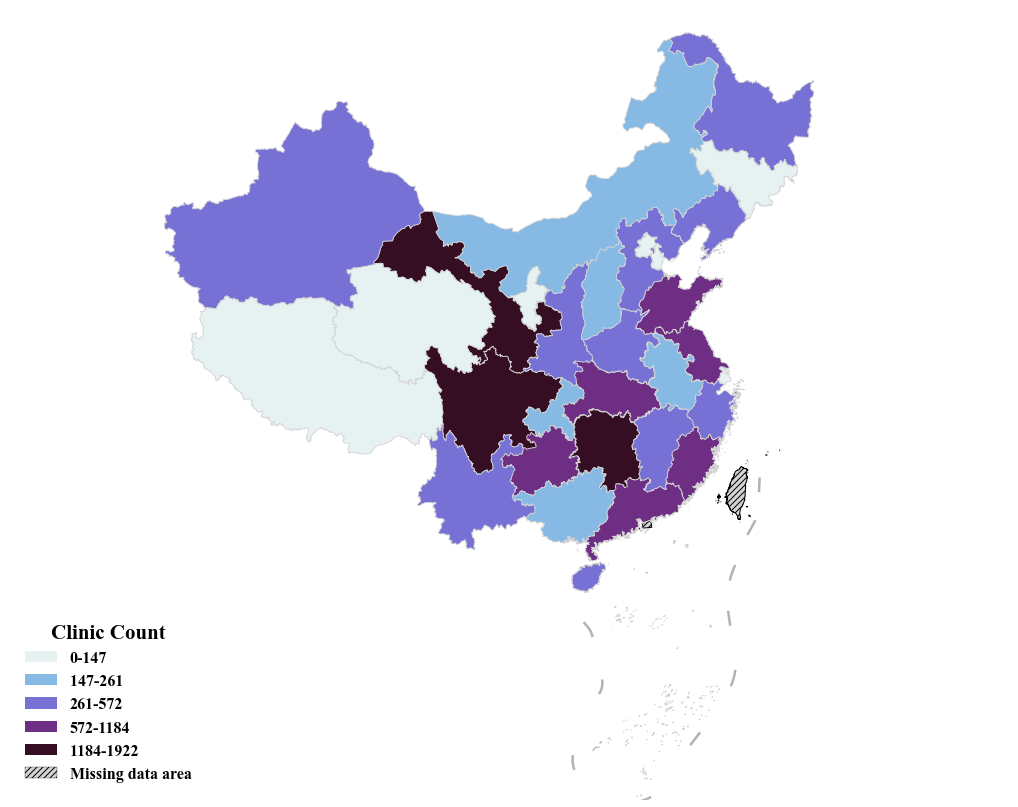

In [2]:
import geopandas as gpd
from shapely import geometry
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mapclassify as mc
import geoplot as gplt
import matplotlib
import matplotlib.patches as mpatches
import geoplot.crs as gcrs
import pyproj
from palettable.cmocean.sequential import Dense_20
from palettable.cmocean.sequential import Dense_20_r
from pprint import pprint

# Read and process data

plt.rcParams['font.family'] = 'Times New Roman'
china = gpd.read_file(r'E:/研究生/china-shapefiles/china.shp' ,
                      encoding = 'utf-8')
china = china.dissolve(by = 'OWNER').reset_index(drop = False)
nine_lines = gpd.read_file(r'E:/研究生/china-shapefiles/china_nine_dotted_line.shp' ,
                           encoding = 'utf-8')
albers_proj = '+proj=aea +lat_1=25 +lat_2=47 +lon_0=105'
raw = pd.read_excel('E:\研究生\疫情数据短评-Scientific data\National Fever Clinics(Chinese Version).xlsx')
province_count = raw.ix[: , '省份'].value_counts()
province_count = pd.DataFrame(province_count)
province_count['province'] = province_count.index
province_count.rename(columns = {'省份' : 'count'} , inplace = True)
province_count
data_with_geometry = pd.merge(left = province_count ,
                              right = china ,
                              left_on = 'province' ,
                              right_on = 'OWNER', 
                              how = 'right').loc[:, ['OWNER', 
                                           'count',
                                           'geometry']]
data_with_geometry = gpd.GeoDataFrame(data_with_geometry , crs = 'EPSG:4326')
data_with_geometry_1 = data_with_geometry.query("OWNER not in ['香港特别行政区' , '澳门特别行政区' , '台湾省']")
data_with_geometry_2 = china.query("OWNER in ['香港特别行政区' , '澳门特别行政区' , '台湾省']")

# Draw figure

ax = gplt.choropleth(df = data_with_geometry_1 , 
                     projection=gcrs.AlbersEqualArea() , 
                     hue = 'count' ,
                     cmap = Dense_20.mpl_colormap ,
                     scheme = mc.JenksCaspall(data_with_geometry_1['count'], k=5) , 
                     figsize = (18,18) ,
                     linewidth = 0.8 , 
                     edgecolor = 'lightgrey')
ax = gplt.polyplot(df = data_with_geometry_2 , 
                   projection=gcrs.AlbersEqualArea() ,
                   ax = ax ,
                   facecolor = 'lightgrey' ,
                   edgecolor = 'black' ,
                   hatch = '////')
ax = gplt.polyplot(df = nine_lines ,
                   projection=gcrs.AlbersEqualArea() , 
                   ax = ax ,
                   linewidth = 2.5 ,
                   edgecolor = 'grey' ,
                   alpha = 0.6 , 
                   extent = china.total_bounds)
ax.axis('off')

# Setup legend

cmaps = plt.get_cmap(Dense_20.mpl_colormap)
bp = mc.JenksCaspall(data_with_geometry_1['count'] , k = 5)
bins = [0] + bp.bins.tolist()
Legend_Element = [mpatches.Patch(facecolor = cmaps(_ * 0.25) , label = f'{int(bins[_])}-{int(bins[_ + 1])}')
                  for _ in range(5)] + \
                 [mpatches.Patch(facecolor = 'lightgrey' , 
                                 edgecolor = 'black' , 
                                 hatch = '////' ,
                                 label = 'Missing data area' ,
                                 linewidth = 0.3)]
ax.legend(handles = Legend_Element ,
          title = 'Clinic Count' ,
          shadow = True , 
          loc = 'lower left' ,
          title_fontsize = 21, 
          fontsize = 16 , 
          borderpad = 0.6 ,
          frameon = False)

# Save figure

plt.savefig(r'E:\\研究生\Figure_1.png' , dpi = 500)

### Draw a histogram of the number of fever clinics in each province (figure 2), the code is as follows: ###

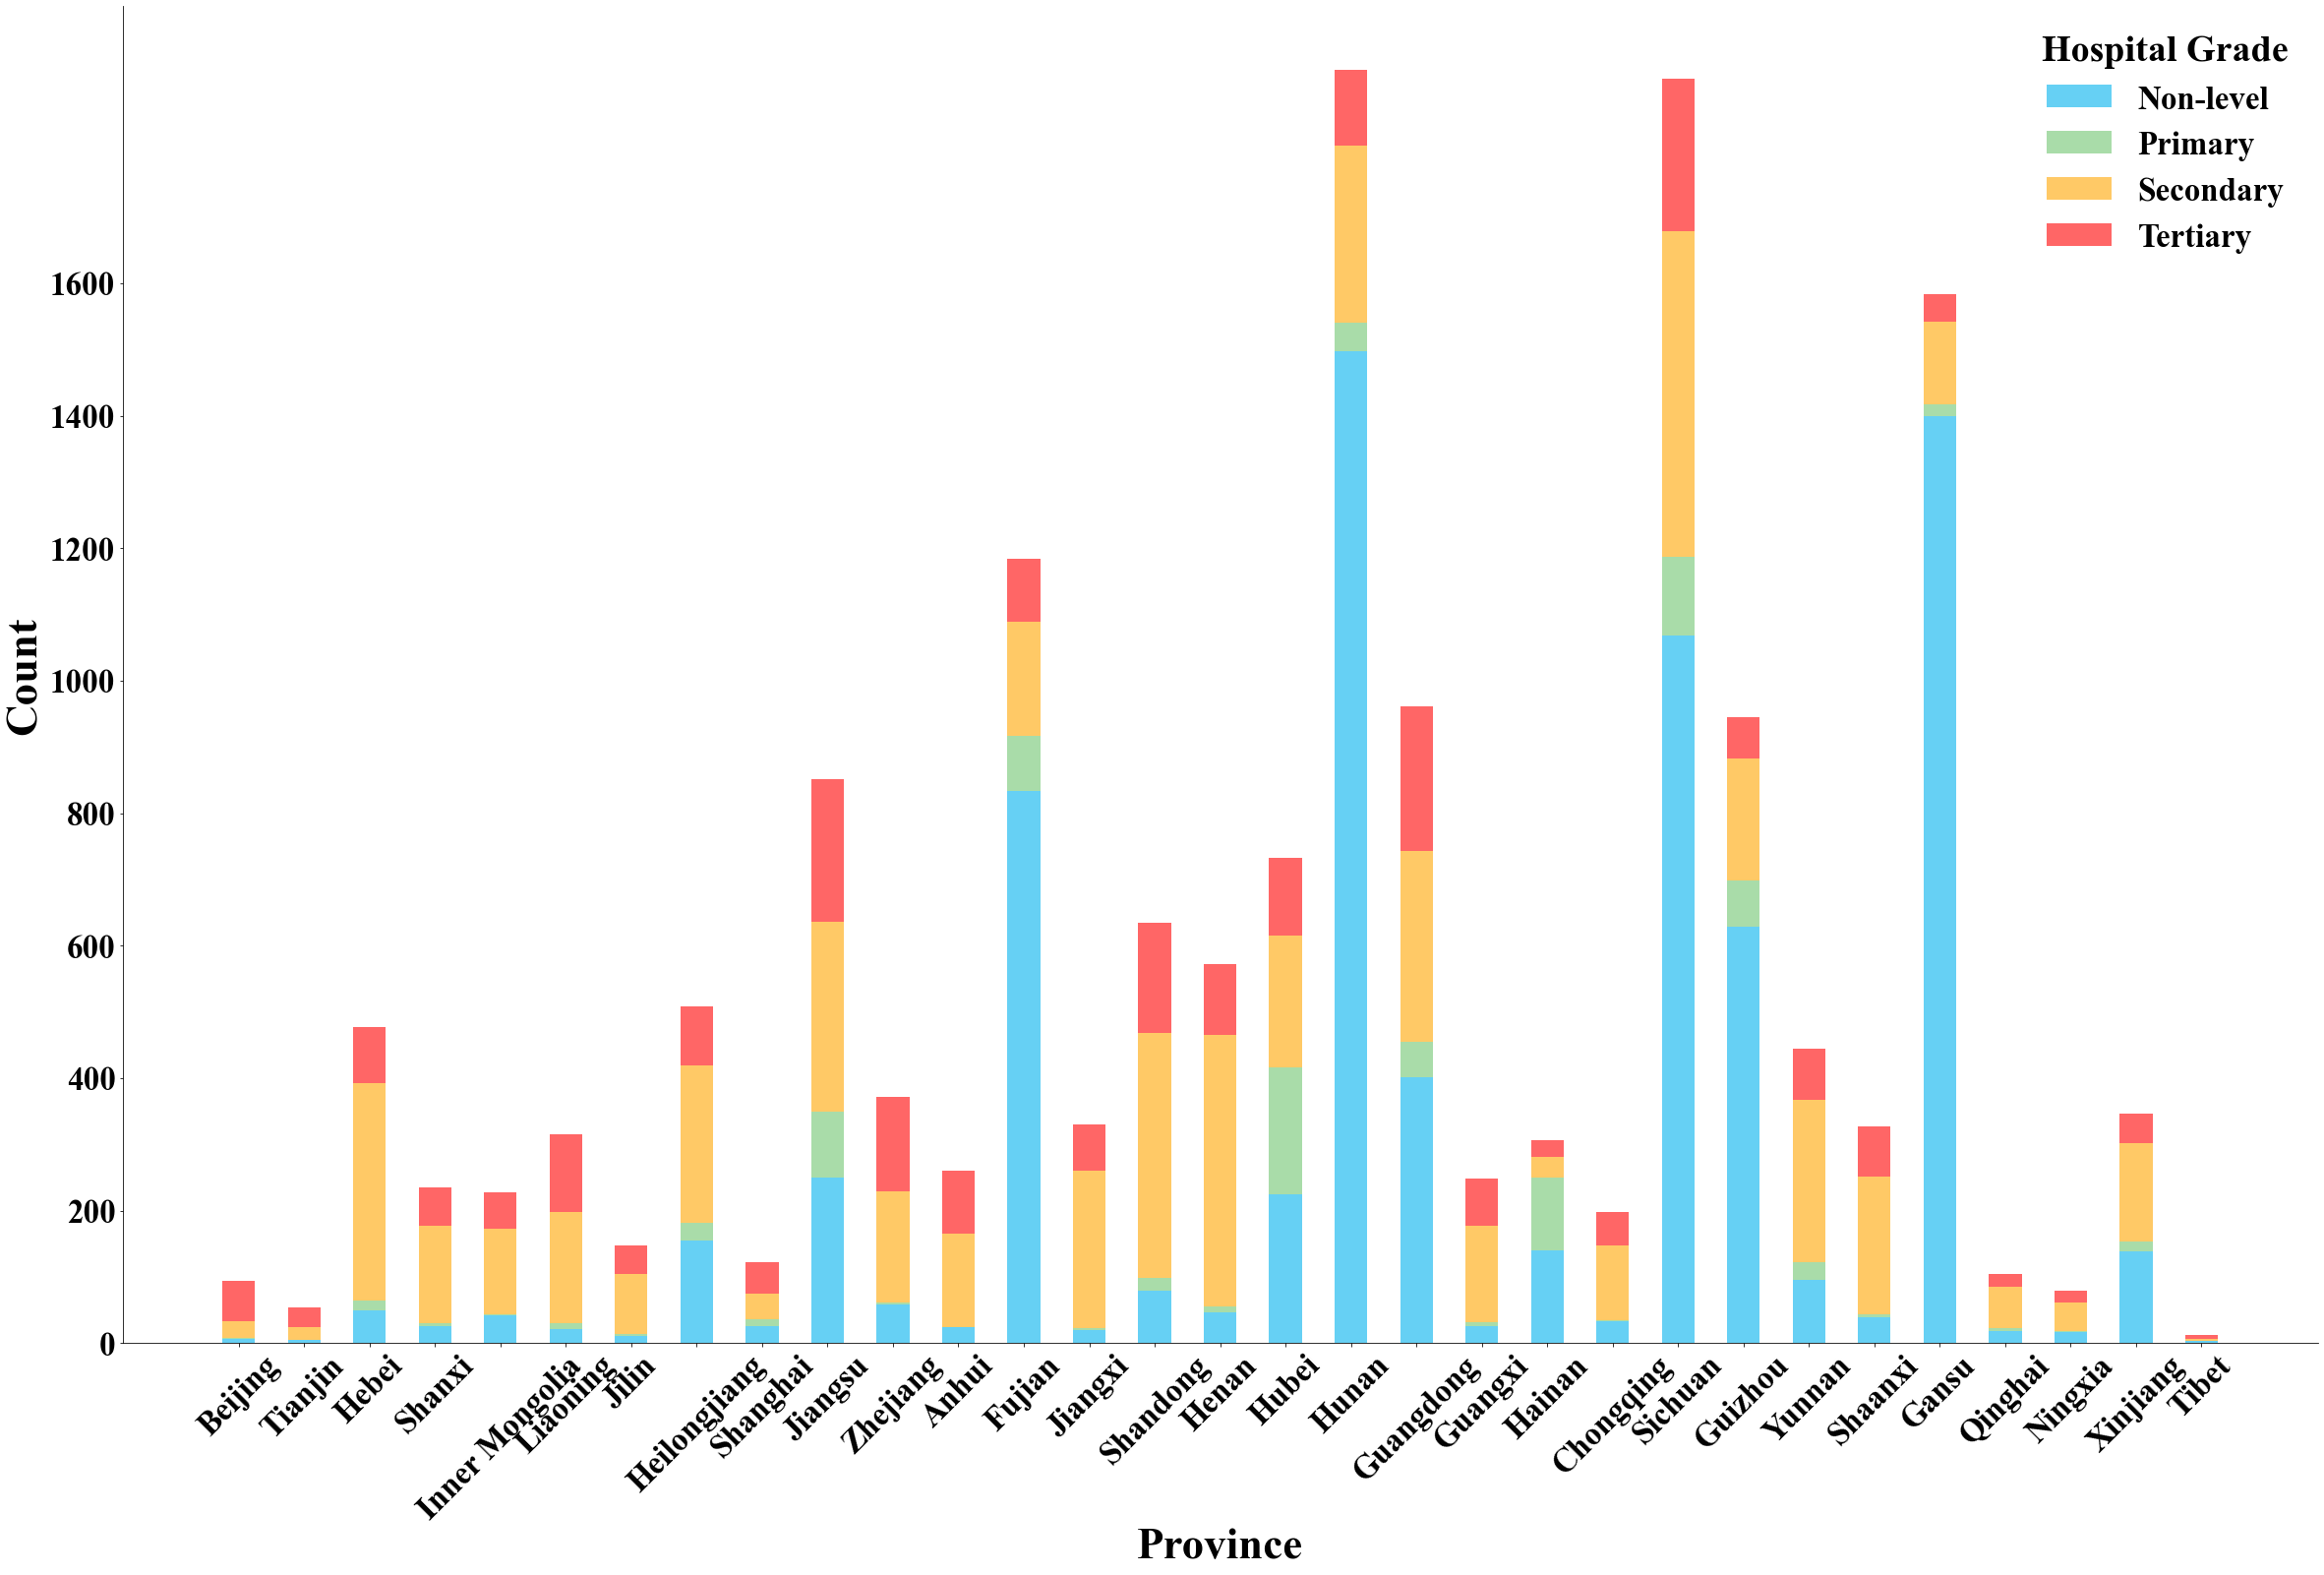

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# Read and process data

data = pd.read_excel(r'E:\研究生\疫情数据短评-Scientific data\National Fever Clinics(English Version).xlsx')
province = data.drop_duplicates(subset = 'Province' , keep = 'first')
province = province['Province']
province = list(province)
third_hospital = []
second_hospital = []
first_hospital = []
non_level_hospital = []
for item in province:
    third = data[(data['Province'] == item) & (data['Hospital_Grade'] == 'Tertiary')]
    second = data[(data['Province'] == item) & (data['Hospital_Grade'] == 'Secondary')]
    first = data[(data['Province'] == item) & (data['Hospital_Grade'] == 'Primary')]
    non_level = data[(data['Province'] == item) & (data['Hospital_Grade'] == 'Non-level')]
    third_hospital.append(len(third))
    second_hospital.append(len(second))
    first_hospital.append(len(first))
    non_level_hospital.append(len(non_level))
x = [i for i in range(31)]
y2 = []
y3 = []
for i , j in zip(non_level_hospital , first_hospital):
    y2.append(i + j)
for i , j in zip(y2 , second_hospital):
    y3.append(i + j)

# Draw figure    

plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.figure(num = 1 , figsize = (40,25))
p1 = plt.bar([i for i in x] , non_level_hospital , width = 0.5 , color = '#00B2EE' , alpha = 0.6)
p2 = plt.bar([i for i in x] , first_hospital , bottom = non_level_hospital , width = 0.5 , color = '#71C671' , alpha = 0.6)
p3 = plt.bar([i for i in x] , second_hospital , bottom = y2 , width = 0.5 , color = 'orange' , alpha = 0.6)
p4 = plt.bar([i for i in x] , third_hospital , bottom = y3 , width = 0.5 , color = '#FF0000' , alpha = 0.6)
plt.xticks([i for i in x] ,
           [i for i in province] ,
           rotation = 45 , size = 33)
plt.yticks([0 , 200 , 400 , 600 , 800 , 1000 , 1200 , 1400 , 1600] , size = 33)
plt.xlabel('Province' , fontproperties = 'Times New Roman' , size = 45)
plt.ylabel('Count' , fontproperties = 'Times New Roman' , size = 45)

# Setup legend

legend = plt.legend(handles = [p1 , p2 , p3 , p4] , labels = ['Non-level' , 'Primary' , 'Secondary' , 'Tertiary'] ,
           loc = 'upper right' , prop = {'family' : 'Times New Roman' , 'size' : 33} , 
           title = 'Hospital Grade' , frameon = False)
legend.get_title().set_fontsize(fontsize = 38)
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# save and show the figure

#plt.savefig(r'E:\\研究生\Figure_2.png' , dpi = 650)
plt.show()

### Collect fever clinics data from Amap API, the code is as follows:

In [ ]:
import json
import requests as req
import sys
import os
import time
import xlwt
import pandas as pd
import socket

# Read data and create url

key = 'eca90a35830d9b399a113cfca96a26fe'
urls  = []
yiyuan = {'Hospital_Name' : [] , 
          'Key_Department' : [] , 
          'Hospital_Grade' : [] , 
          'Address' : [] , 
          'Coordinate' : [] , 
          'Province' : [] , 
          'City' : [] , 
          'District_County' : []}
citys = pd.read_excel('E:\研究生\高德地图API编码\城市编码表.xlsx' , converters =  {u'城市编码':str})
cityscode = citys['城市编码']
for code in cityscode:
    citycode = str(code)
    for i in range(1 , 21):
        page = str(i)
        url =  'https://restapi.amap.com/v3/place/text?keywords=发热门诊&city=' + citycode + '&output=json&offset=15&page=' + page + '&key=' + key + '&extensions=all'
        urls.append(url)
print(time.time())
print('start')

# Crawl data

for url in urls:
    time.sleep(0.5)
    html = req.get(url) # Read html
    data = html.json()  # Transform the format of html information into json format
    print(data)
    if data['count'] != 0:
        for item in data['pois']:
            if 'name' in item.keys() and 'tag' in item.keys() and 'type' in item.keys() and 'address' in item.keys() and 'location' in item.keys() and 'pname' in item.keys() and 'cityname' in item.keys() and 'adname' in item.keys():
                hname = item['name']
                hkeshi = item['tag']
                htype = item['type']
                hadd = item['address']
                hloc = item['location']
                hpro = item['pname']
                hcity = item['cityname']
                had = item['adname']
                yiyuan['Hospital_Name'].append(hname)
                yiyuan['Key_Department'].append(hkeshi)
                yiyuan['Hospital_Grade'].append(htype)
                yiyuan['Address'].append(hadd)
                yiyuan['Coordinate'].append(hloc)
                yiyuan['Province'].append(hpro)
                yiyuan['City'].append(hcity)
                yiyuan['District_County'].append(had)
            else:
                continue
    else:
        continue
    html.close()
print('Data Crawl Completed')

# Organize and save data

shujvbiao = pd.DataFrame(yiyuan)
shujvbiao.to_excel('E:\研究生\Fever_Clinic.xlsx')
print('Data is saved locally')

### Trandform the format of coordinate from GCJ02 to WGS84，the code is as follows:

In [ ]:
import pandas as pd
import math
from xlutils.copy import copy

# Read and process data

data = pd.read_excel('E:\研究生\Fever_Clinic.xlsx')
jingdu = data['Longitude']
weidu = data['Latitude']

# setup transform function

def GCJ2WGS(m , n):
    lon = m
    lat = n
    a = 6378245.0
    ee = 0.00669342162296594323
    PI = math.pi
    x = lon - 105.0
    y = lat - 35.0
    dLon = 300.0 + x + 2.0 * y + 0.1 * x * x + 0.1 * x * y + 0.1 * math.sqrt(abs(x))
    dLon += (20.0 * math.sin(6.0 * x * PI) + 20.0 * math.sin(2.0 * x * PI)) * 2.0 / 3.0
    dLon += (20.0 * math.sin(x * PI) + 40.0 * math.sin(x / 3.0 * PI)) * 2.0 / 3.0
    dLon += (150.0 * math.sin(x / 12.0 * PI) + 300.0 * math.sin(x / 30.0 * PI)) * 2.0 / 3.0
    dLat = -100.0 + 2.0 * x + 3.0 * y + 0.2 * y * y + 0.1 * x * y + 0.2 * math.sqrt(abs(x))
    dLat += (20.0 * math.sin(6.0 * x * PI) + 20.0 * math.sin(2.0 * x * PI)) * 2.0 / 3.0
    dLat += (20.0 * math.sin(y * PI) + 40.0 * math.sin(y / 3.0 * PI)) * 2.0 / 3.0
    dLat += (160.0 * math.sin(y / 12.0 * PI) + 320 * math.sin(y * PI / 30.0)) * 2.0 / 3.0
    radLat = lat / 180.0 * PI
    magic = math.sin(radLat)
    magic = 1 - ee * magic * magic
    sqrtMagic = math.sqrt(magic)
    dLat = (dLat * 180.0) / ((a * (1 - ee)) / (magic * sqrtMagic) * PI)
    dLon = (dLon * 180.0) / (a / sqrtMagic * math.cos(radLat) * PI)
    wgsLon = lon - dLon
    wgsLat = lat - dLat
    return wgsLon,wgsLat

# Perform conversion operations

WGS = {'Longitude_WGS84' : [],
       'Latitude_WGS84' : []}
for i in range(0 , len(jingdu)):
    ma = GCJ2WGS(jingdu[i] , weidu[i])
    WGS['Longitutde_WGS84'].append(ma[0])
    WGS['Latitude_WGS84'].append(ma[1])

# Organize and save data    

k = pd.DataFrame(WGS)
k.to_excel('E:\研究生\Coordinte_WGS84.xlsx')
print("Conversion complete")

### Extract BD09 coordinates according to address information based on Baidu Map API, the code is as follows:

In [ ]:
import json
import requests as req
import sys
import os
import time
import xlwt
import pandas as pd
import socket

# Read data and create url

socket.setdefaulttimeout(20)
ty = sys.getfilesystemencoding()
ak = 'XokDzF9ylqjePtj4AalPmSxnmkCGeWrd' 
print(time.time())
print('start')
zuobiao = { 'Latitude' : [] , 'Longitude' : []}
urls = []
shujv = pd.read_excel('E:\研究生\Fever_Clinics.xlsx')
dizhi = shujv['Address']
chengshi = shujv['City']
for i in range (0,len(dizhi)):
    address = dizhi[i]
    city = chengshi[i]
    url = 'http://api.map.baidu.com/geocoding/v3/?address=' + str(address) + '&city=' + str(city) + '&output=json&ak=' + ak
    urls.append(url)
print('url list reading complete')

# Crawl BD09 coordinates

for url in urls:
    time.sleep(1) 
    html = req.get(url) # Read html
    data = html.json()  # Transform the format of html information into json format
    print(data)
    if data['status'] == 0:
        item = data['result']
        jlat = item['location']['lat']
        jlng = item['location']['lng']
        zuobiao['Latitude'].append(jlat)
        zuobiao['Longitude'].append(jlng)
    else:
        jlat = 'None'
        jlng = 'None'
        zuobiao['Latitude'].append(jlat)
        zuobiao['Longitude'].append(jlng)
    html.close()
print('Data Crawl Completed')

# Organize and save data

shujvbiao = pd.DataFrame(zuobiao)
shujvbiao.to_excel('E:\研究生\Coordinte_BD09.xlsx')
print('Data is saved locally')

### Trandform the format of coordinate from BD09 to WGS84，the code is as follows:

In [ ]:
import pandas as pd
import math
from xlutils.copy import copy

# Read and process data

data = pd.read_excel('E:\研究生\Fever_Clinic.xlsx')
jingdu = data['Longitude']
weidu = data['Latitude']

# setup transform function

def BD09_to_WGS84(bd_lng , bd_lat):
    a = 6378245.0
    ee = 0.00669342162296594323
    PI = math.pi
    x_pi = 3.14159265358979324 * 3000.0 / 180.0
    x = bd_lng - 0.0065
    y = bd_lat - 0.006
    z = math.sqrt(x * x + y * y) - 0.00002 * math.sin(y * x_pi)
    theta = math.atan2(y , x) - 0.000003 * math.cos(x * x_pi)
    gcj_lng = z * math.cos(theta)
    gcj_lat = z * math.sin(theta)
    lat = gcj_lat - 35.0
    lng = gcj_lng - 105.0
    dlat = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + \
              0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    dlat += (20.0 * math.sin(6.0 * lng * PI) + 20.0 *
                math.sin(2.0 * lng * PI)) * 2.0 / 3.0
    dlat += (20.0 * math.sin(lat * PI) + 40.0 *
                math.sin(lat / 3.0 * PI)) * 2.0 / 3.0
    dlat += (160.0 * math.sin(lat / 12.0 * PI) + 320 *
                math.sin(lat * PI / 30.0)) * 2.0 / 3.0
    dlng = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + \
              0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    dlng += (20.0 * math.sin(6.0 * lng * PI) + 20.0 *
                math.sin(2.0 * lng * PI)) * 2.0 / 3.0
    dlng += (20.0 * math.sin(lng * PI) + 40.0 *
                math.sin(lng / 3.0 * PI)) * 2.0 / 3.0
    dlng += (150.0 * math.sin(lng / 12.0 * PI) + 300.0 *
                math.sin(lng / 30.0 * PI)) * 2.0 / 3.0
    radlat = gcj_lat / 180 * PI
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * PI)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * PI)
    mglat = gci_lat + dlat
    mglng = gcj_lng + dlng
    wgslng = gcj_lng * 2 - mglng
    wgslat = gci_lat * 2 - mglat
    return wgslng , wgslat

# Perform conversion operations

WGS = {'Longitude_WGS84' : [],
       'Latitude_WGS84' : []}
for i in range(0 , len(jingdu)):
    ma = BD09_to_WGS84(jingdu[i] , weidu[i])
    WGS['Longitude_WGS84'].append(ma[0])
    WGS['Latitude_WGS84'].append(ma[1])

# Organize and save data    

k = pd.DataFrame(WGS)
k.to_excel('E:\研究生\Coordinte_WGS84.xlsx')
print("Conversion complete")